# Compare Data and Simulated spectra
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS
- creation date   : June 20th 2017
- re-written after new simulation SimulateSpectrum : 18th October 2017


In [6]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
print theNotebook

AnaCompareDataSimSpec


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
AnaCompareDataSimSpec
ccdproc version 1.3.0.post1
bottleneck version 1.3.2
/Users/dagoret/MacOSX/GitHub/LSST/CTIOAnaJun2017/CTIOAnaJun2017/ana_31may17/HD111980_2


In [9]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")


Bad key "axes.color_cycle" on line 215 in
../../templates/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [10]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'figure.figsize' : (10, 5)})

In [11]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Initialisation

## Input

In [12]:
inputdir="./simandcalibspec"
MIN_IMGNUMBER=74
MAX_IMGNUMBER=108
date="20170531"
object_name='HD111980'
tag = "calibandSimSpectra"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

## Output Fits file

In [13]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

In [14]:
outputdir="./spectrum_compdatasim"

In [15]:
ensure_dir(outputdir)

# Open Input Files

In [16]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe)

In [17]:
sorted_numbers

array([ 74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108])

In [18]:
sorted_files

array(['./simandcalibspec/calibandSimSpectra_20170531_074.fits',
       './simandcalibspec/calibandSimSpectra_20170531_075.fits',
       './simandcalibspec/calibandSimSpectra_20170531_076.fits',
       './simandcalibspec/calibandSimSpectra_20170531_077.fits',
       './simandcalibspec/calibandSimSpectra_20170531_078.fits',
       './simandcalibspec/calibandSimSpectra_20170531_079.fits',
       './simandcalibspec/calibandSimSpectra_20170531_080.fits',
       './simandcalibspec/calibandSimSpectra_20170531_081.fits',
       './simandcalibspec/calibandSimSpectra_20170531_082.fits',
       './simandcalibspec/calibandSimSpectra_20170531_083.fits',
       './simandcalibspec/calibandSimSpectra_20170531_084.fits',
       './simandcalibspec/calibandSimSpectra_20170531_085.fits',
       './simandcalibspec/calibandSimSpectra_20170531_086.fits',
       './simandcalibspec/calibandSimSpectra_20170531_087.fits',
       './simandcalibspec/calibandSimSpectra_20170531_088.fits',
       './simandcalibspec

In [19]:

all_headers, \
all_dates, \
all_objects, \
all_airmass, \
all_titles, \
all_exposures, \
all_ut, all_ra,all_dec,all_epoch,all_zenith,all_ha,all_st,all_alt,all_focus,\
all_temp, all_press,all_hum,all_windsp,\
all_seeing,all_seeingam,\
all_filt,all_filt1,all_filt2,\
all_leftspectra_data, \
all_rightspectra_data, \
all_leftspectra_data_stat_err ,\
all_rightspectra_data_stat_err ,\
all_leftspectra_wl,\
all_rightspectra_wl, \
all_totleftspectra_data, \
all_totrightspectra_data, \
all_sim_spectra_wl, \
all_sim_spectra_data=BuildCalibandSimSpecFull(sorted_files,sorted_numbers)

## Clean Spectra

- storage add trailing empty bins ..

In [20]:
all_sim_spectra_wl_cut,all_sim_spectra_data_cut=RemoveBadWavelengths(all_sim_spectra_wl,all_sim_spectra_data)

In [21]:
all_leftspectra_wl_cut,all_leftspectra_data_cut=RemoveBadWavelengths(all_leftspectra_wl,all_leftspectra_data)
all_rightspectra_wl_cut,all_rightspectra_data_cut=RemoveBadWavelengths(all_rightspectra_wl,all_rightspectra_data)

all_leftspectra_wl_cut,all_totleftspectra_data_cut=RemoveBadWavelengths(all_leftspectra_wl,all_totleftspectra_data)
all_rightspectra_wl_cut,all_totrightspectra_data_cut=RemoveBadWavelengths(all_rightspectra_wl,all_totrightspectra_data)

all_leftspectra_wl_cut,all_leftspectra_data_stat_err_cut=RemoveBadWavelengths(all_leftspectra_wl,all_leftspectra_data_stat_err)
all_rightspectra_wl_cut,all_rightspectra_data_stat_err_cut=RemoveBadWavelengths(all_rightspectra_wl,all_rightspectra_data_stat_err)

In [22]:
all_sim_spectra_wl,all_sim_spectra_data=all_sim_spectra_wl_cut,all_sim_spectra_data_cut

In [23]:
all_rightspectra_wl,all_rightspectra_data=all_rightspectra_wl_cut,all_rightspectra_data_cut

In [24]:
all_totleftspectra_data=all_totleftspectra_data_cut
all_totrightspectra_data=all_totrightspectra_data_cut
all_rightspectra_data_stat_err=all_rightspectra_data_stat_err_cut
all_leftspectra_data_stat_err=all_leftspectra_data_stat_err_cut

## Check

In [25]:
NDATA=len(all_headers)

for idx in range(NDATA):
    print idx,all_headers[idx]["FILTERS"]

0 RG715 Ron400
1 RG715 Thor300
2 RG715 HoloPhP
3 RG715 HoloPhAg
4 RG715 HoloAmAg
5 RG715 Ron400
6 RG715 Thor300
7 RG715 HoloPhP
8 RG715 HoloPhAg
9 RG715 HoloAmAg
10 RG715 Ron400
11 RG715 Thor300
12 RG715 HoloPhP
13 RG715 HoloPhAg
14 RG715 HoloAmAg
15 RG715 Ron400
16 RG715 Thor300
17 RG715 HoloPhP
18 RG715 HoloPhAg
19 RG715 HoloAmAg
20 RG715 Ron400
21 RG715 Thor300
22 RG715 HoloPhP
23 RG715 HoloPhAg
24 RG715 HoloAmAg
25 RG715 Ron400
26 RG715 Thor300
27 RG715 HoloPhP
28 RG715 HoloPhAg
29 RG715 HoloAmAg
30 RG715 Ron400
31 RG715 Thor300
32 RG715 HoloPhP
33 RG715 HoloPhAg
34 RG715 HoloAmAg


# Analysis

## Dispersers

In [26]:
filt0_idx,filt1_idx,filt2_idx,filt3_idx,filt4_idx,filt5_idx,filt6_idx=get_filt_idx(all_filt)

In [27]:
print  Filt_names[0],' \t : filt0_idx :: ',filt0_idx
print  Filt_names[1],' \t : filt1_idx :: ',filt1_idx
print  Filt_names[2],' \t : filt2_idx :: ',filt2_idx
print  Filt_names[3],' \t : filt3_idx :: ',filt3_idx
print  Filt_names[4],' \t : filt4_idx :: ',filt4_idx
print  Filt_names[5],' \t : filt5_idx :: ',filt5_idx
print  Filt_names[6],' \t : filt6_idx :: ',filt6_idx

dia Ron400  	 : filt0_idx ::  [ 0  5 10 15 20 25 30]
dia Thor300  	 : filt1_idx ::  [ 1  6 11 16 21 26 31]
dia HoloPhP  	 : filt2_idx ::  [ 2  7 12 17 22 27 32]
dia HoloPhAg  	 : filt3_idx ::  [ 3  8 13 18 23 28 33]
dia HoloAmAg  	 : filt4_idx ::  [ 4  9 14 19 24 29 34]
dia Ron200  	 : filt5_idx ::  []
Unknown  	 : filt6_idx ::  []


In [28]:
Thor300_index=np.array(filt1_idx)
Ron400_index=np.array(filt0_idx)
HoloPhP_index=np.array(filt2_idx)
HoloPhAg_index=np.array(filt3_idx)
HoloAmAg_index=np.array(filt4_idx)
Ron200_index=np.array(filt5_idx)

## Airmass

/Users/dagoret/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


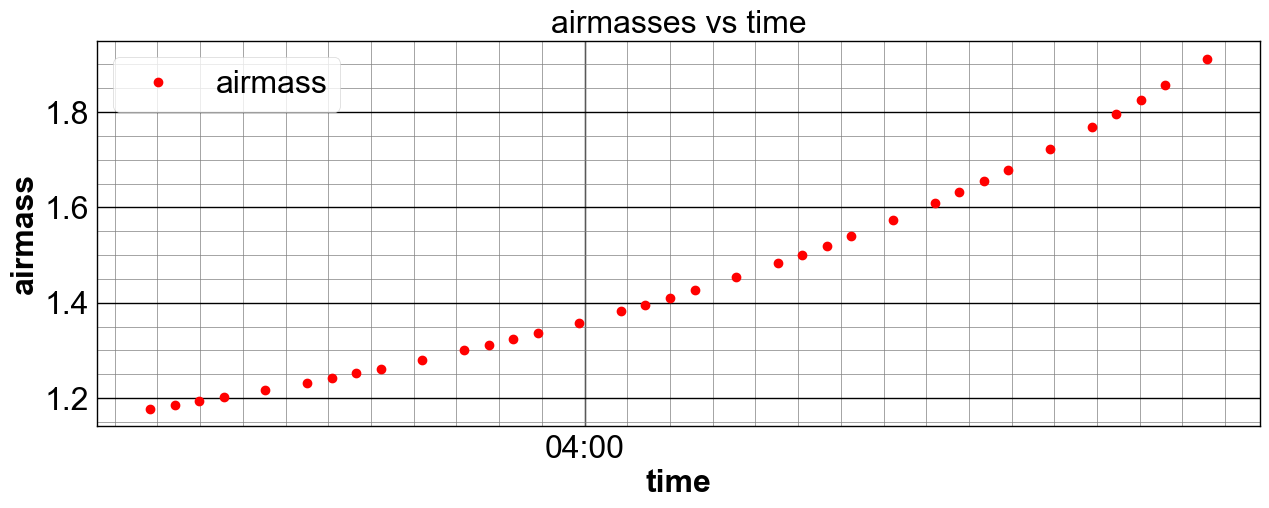

In [29]:
PlotDataVsDateTime(all_dates,all_airmass,"airmasses vs time","time","airmass",dir_top_images,'airmass_vs_time.pdf')

## Show Spectra
==========================

In [30]:
NDATA=len(all_rightspectra_data)

### Work only on right spectra

/Users/dagoret/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


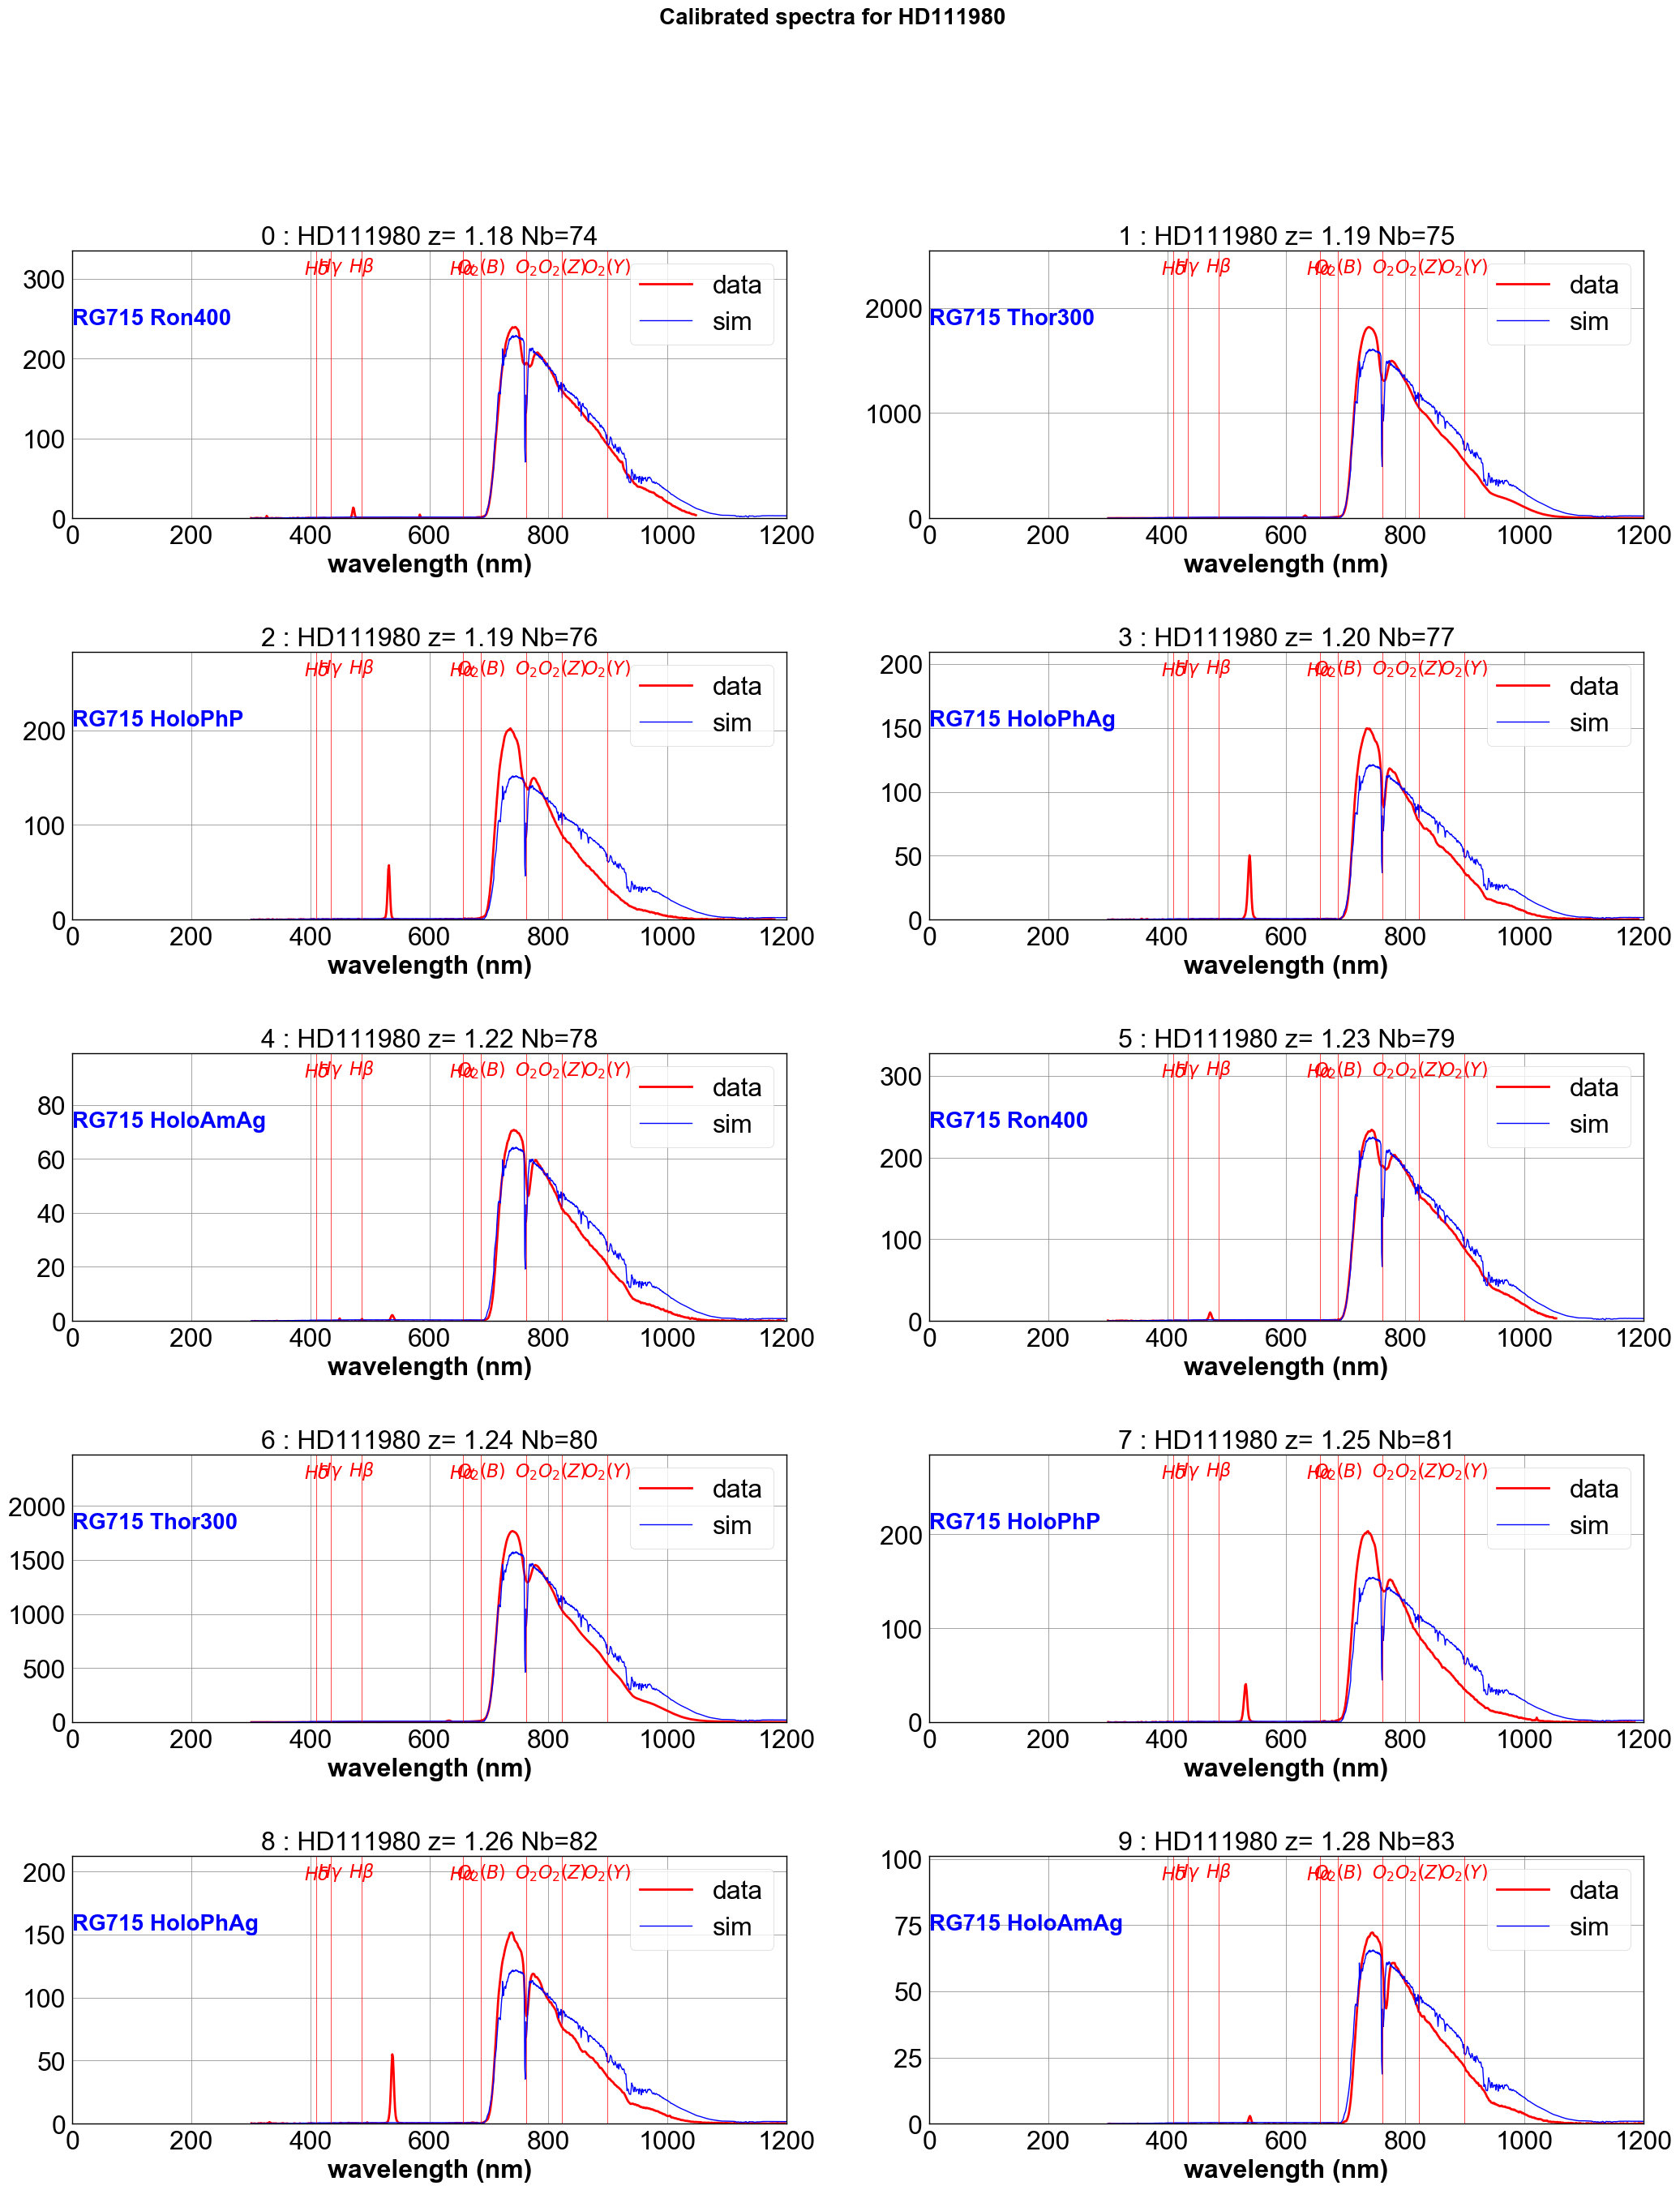

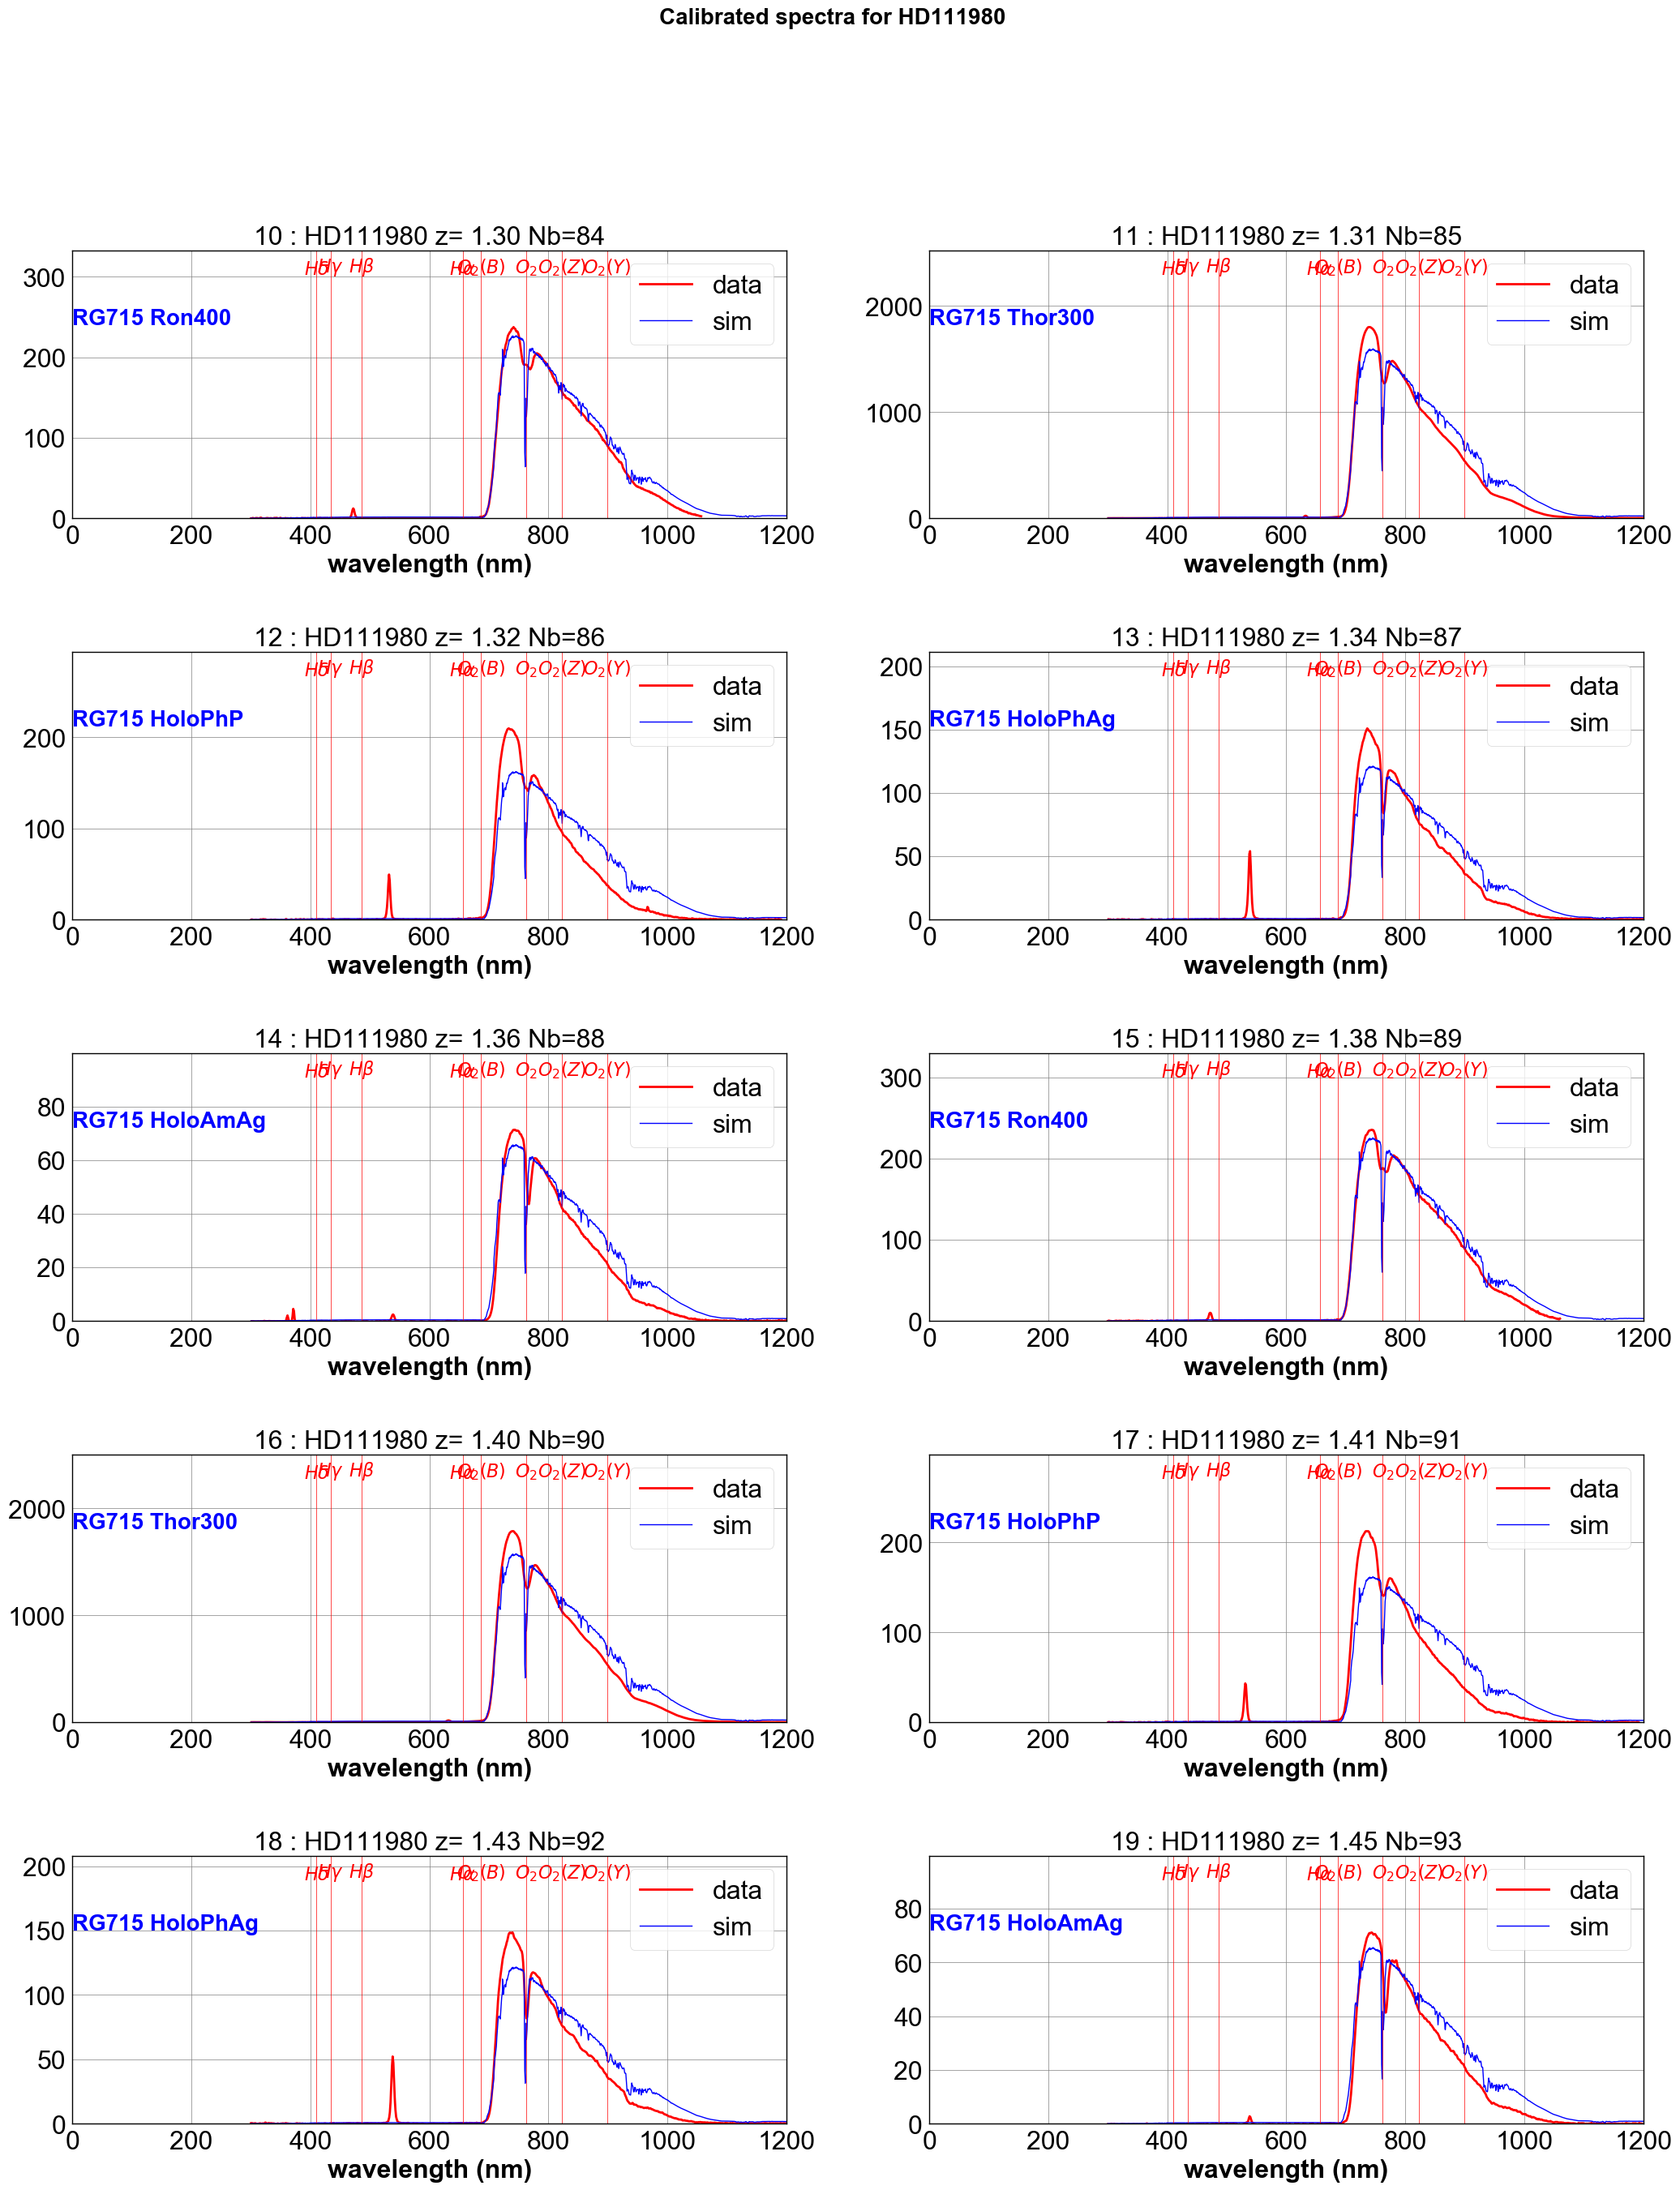

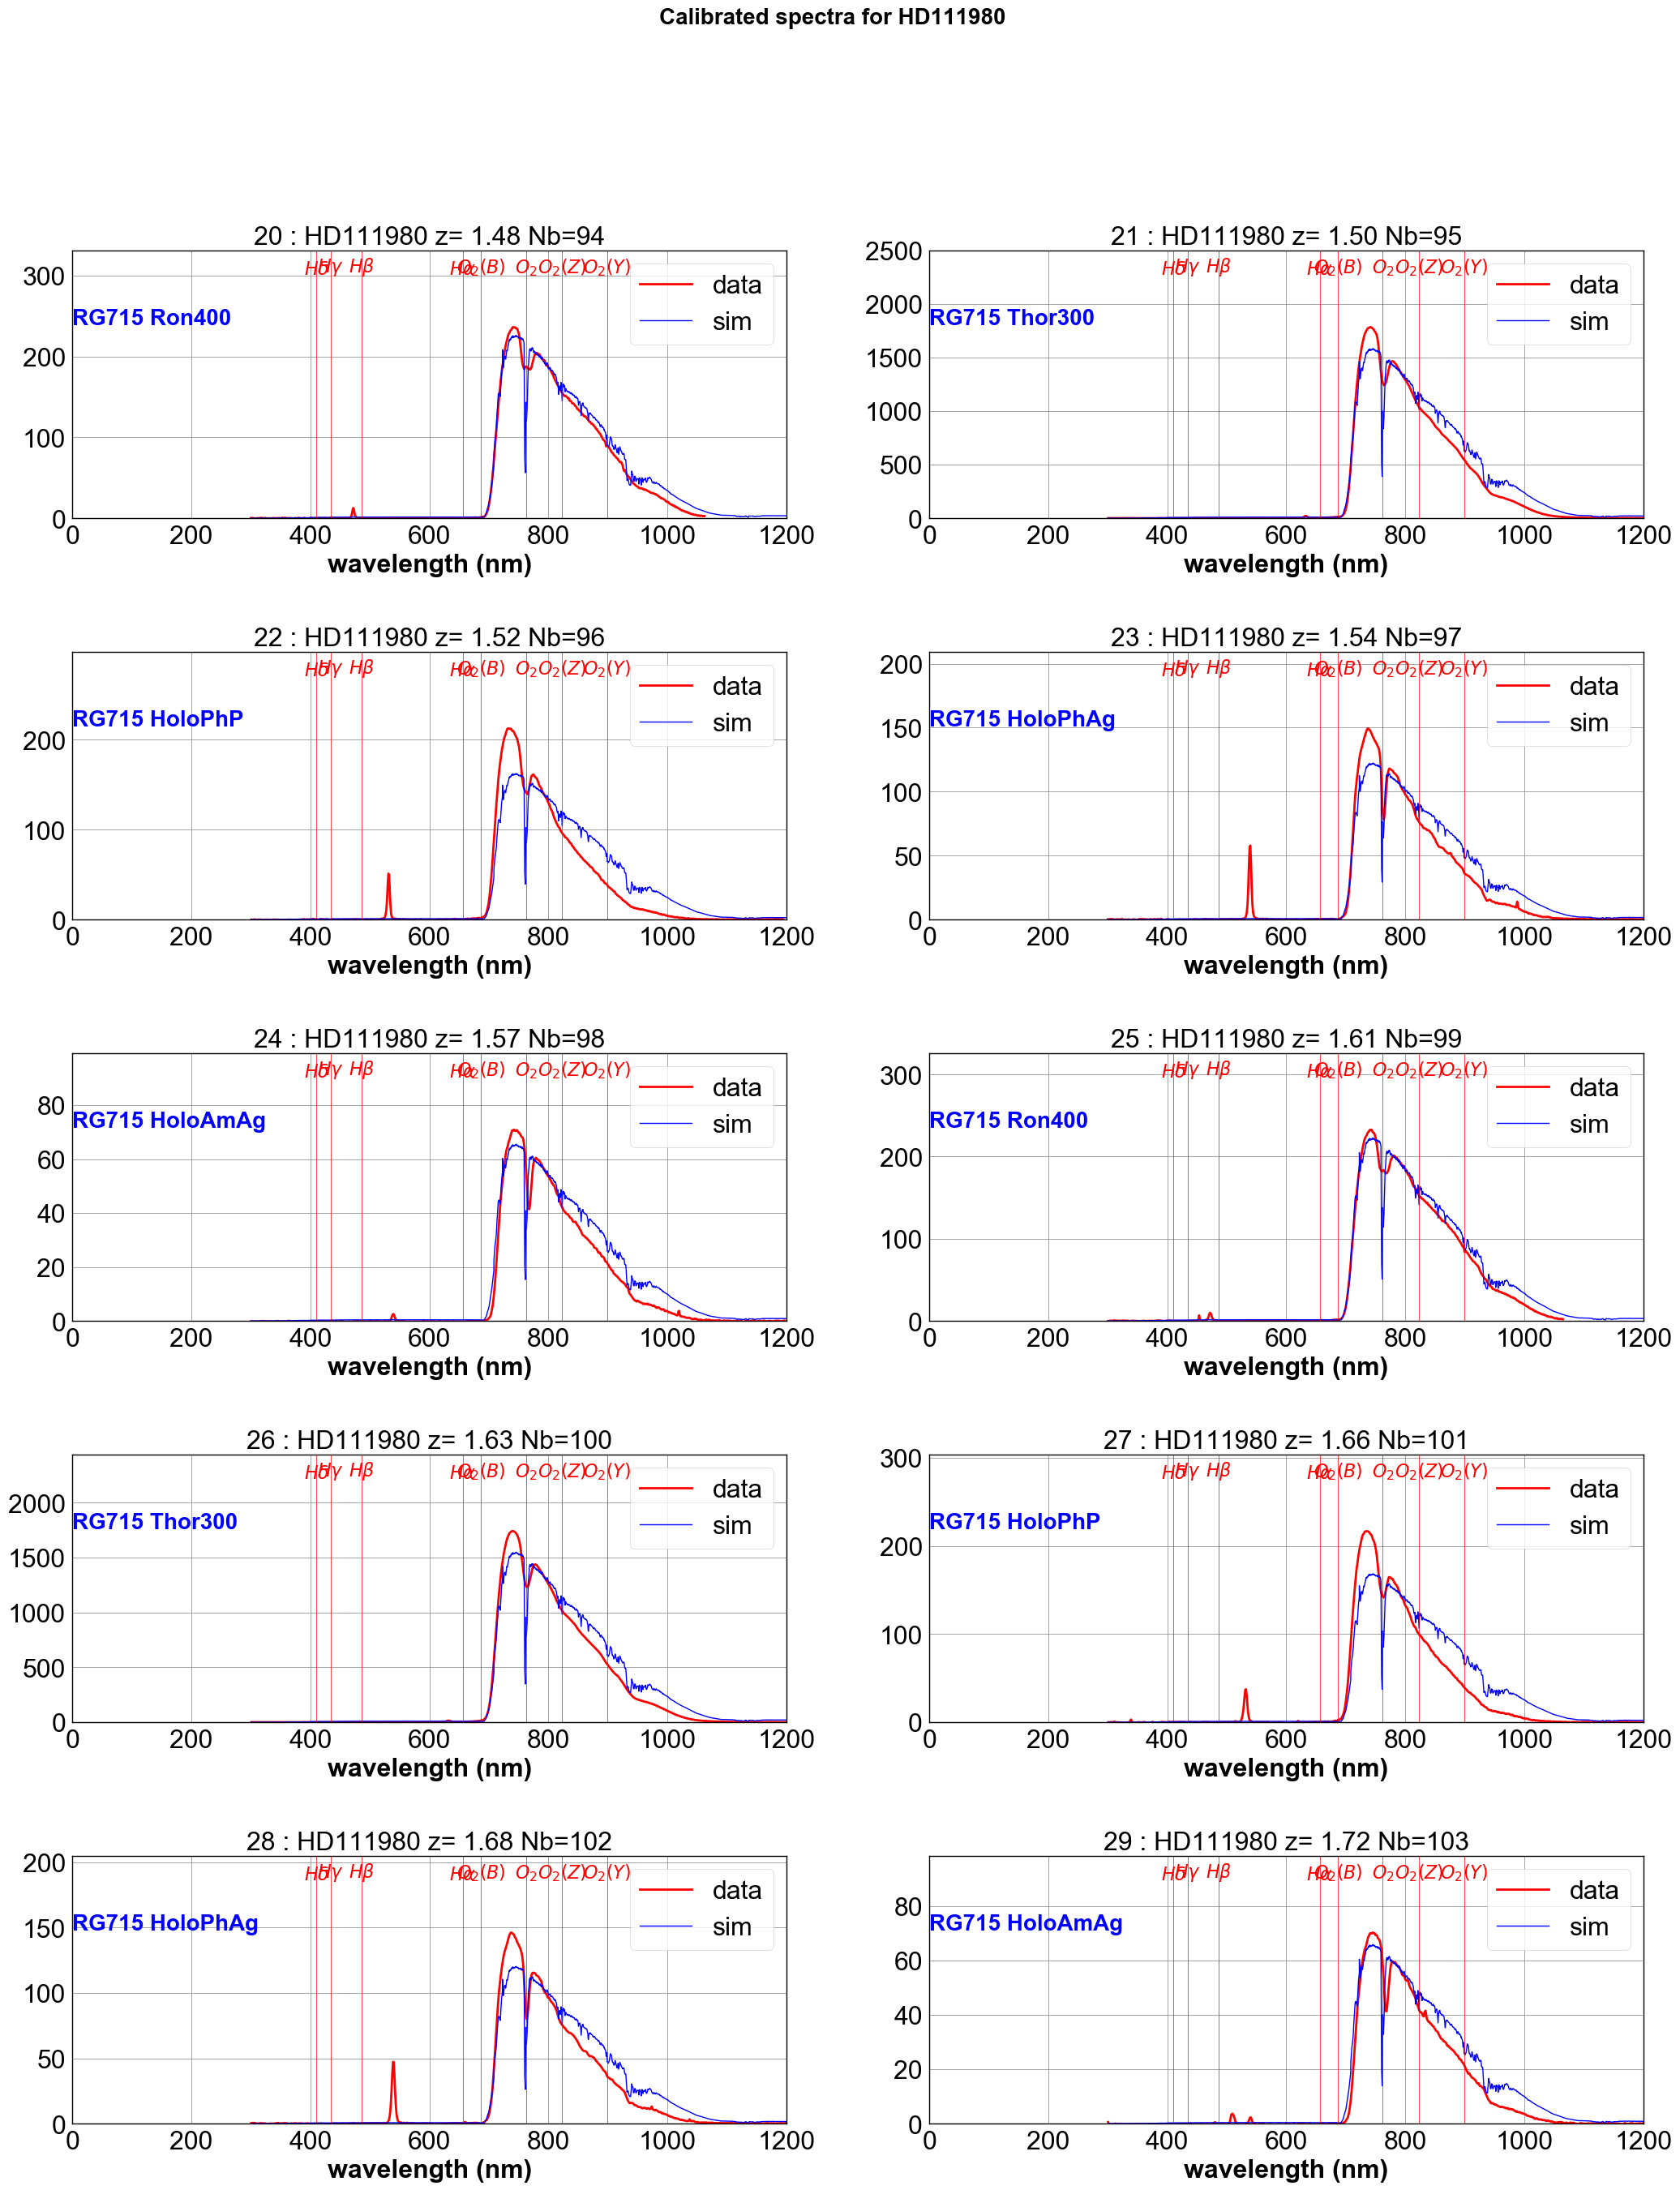

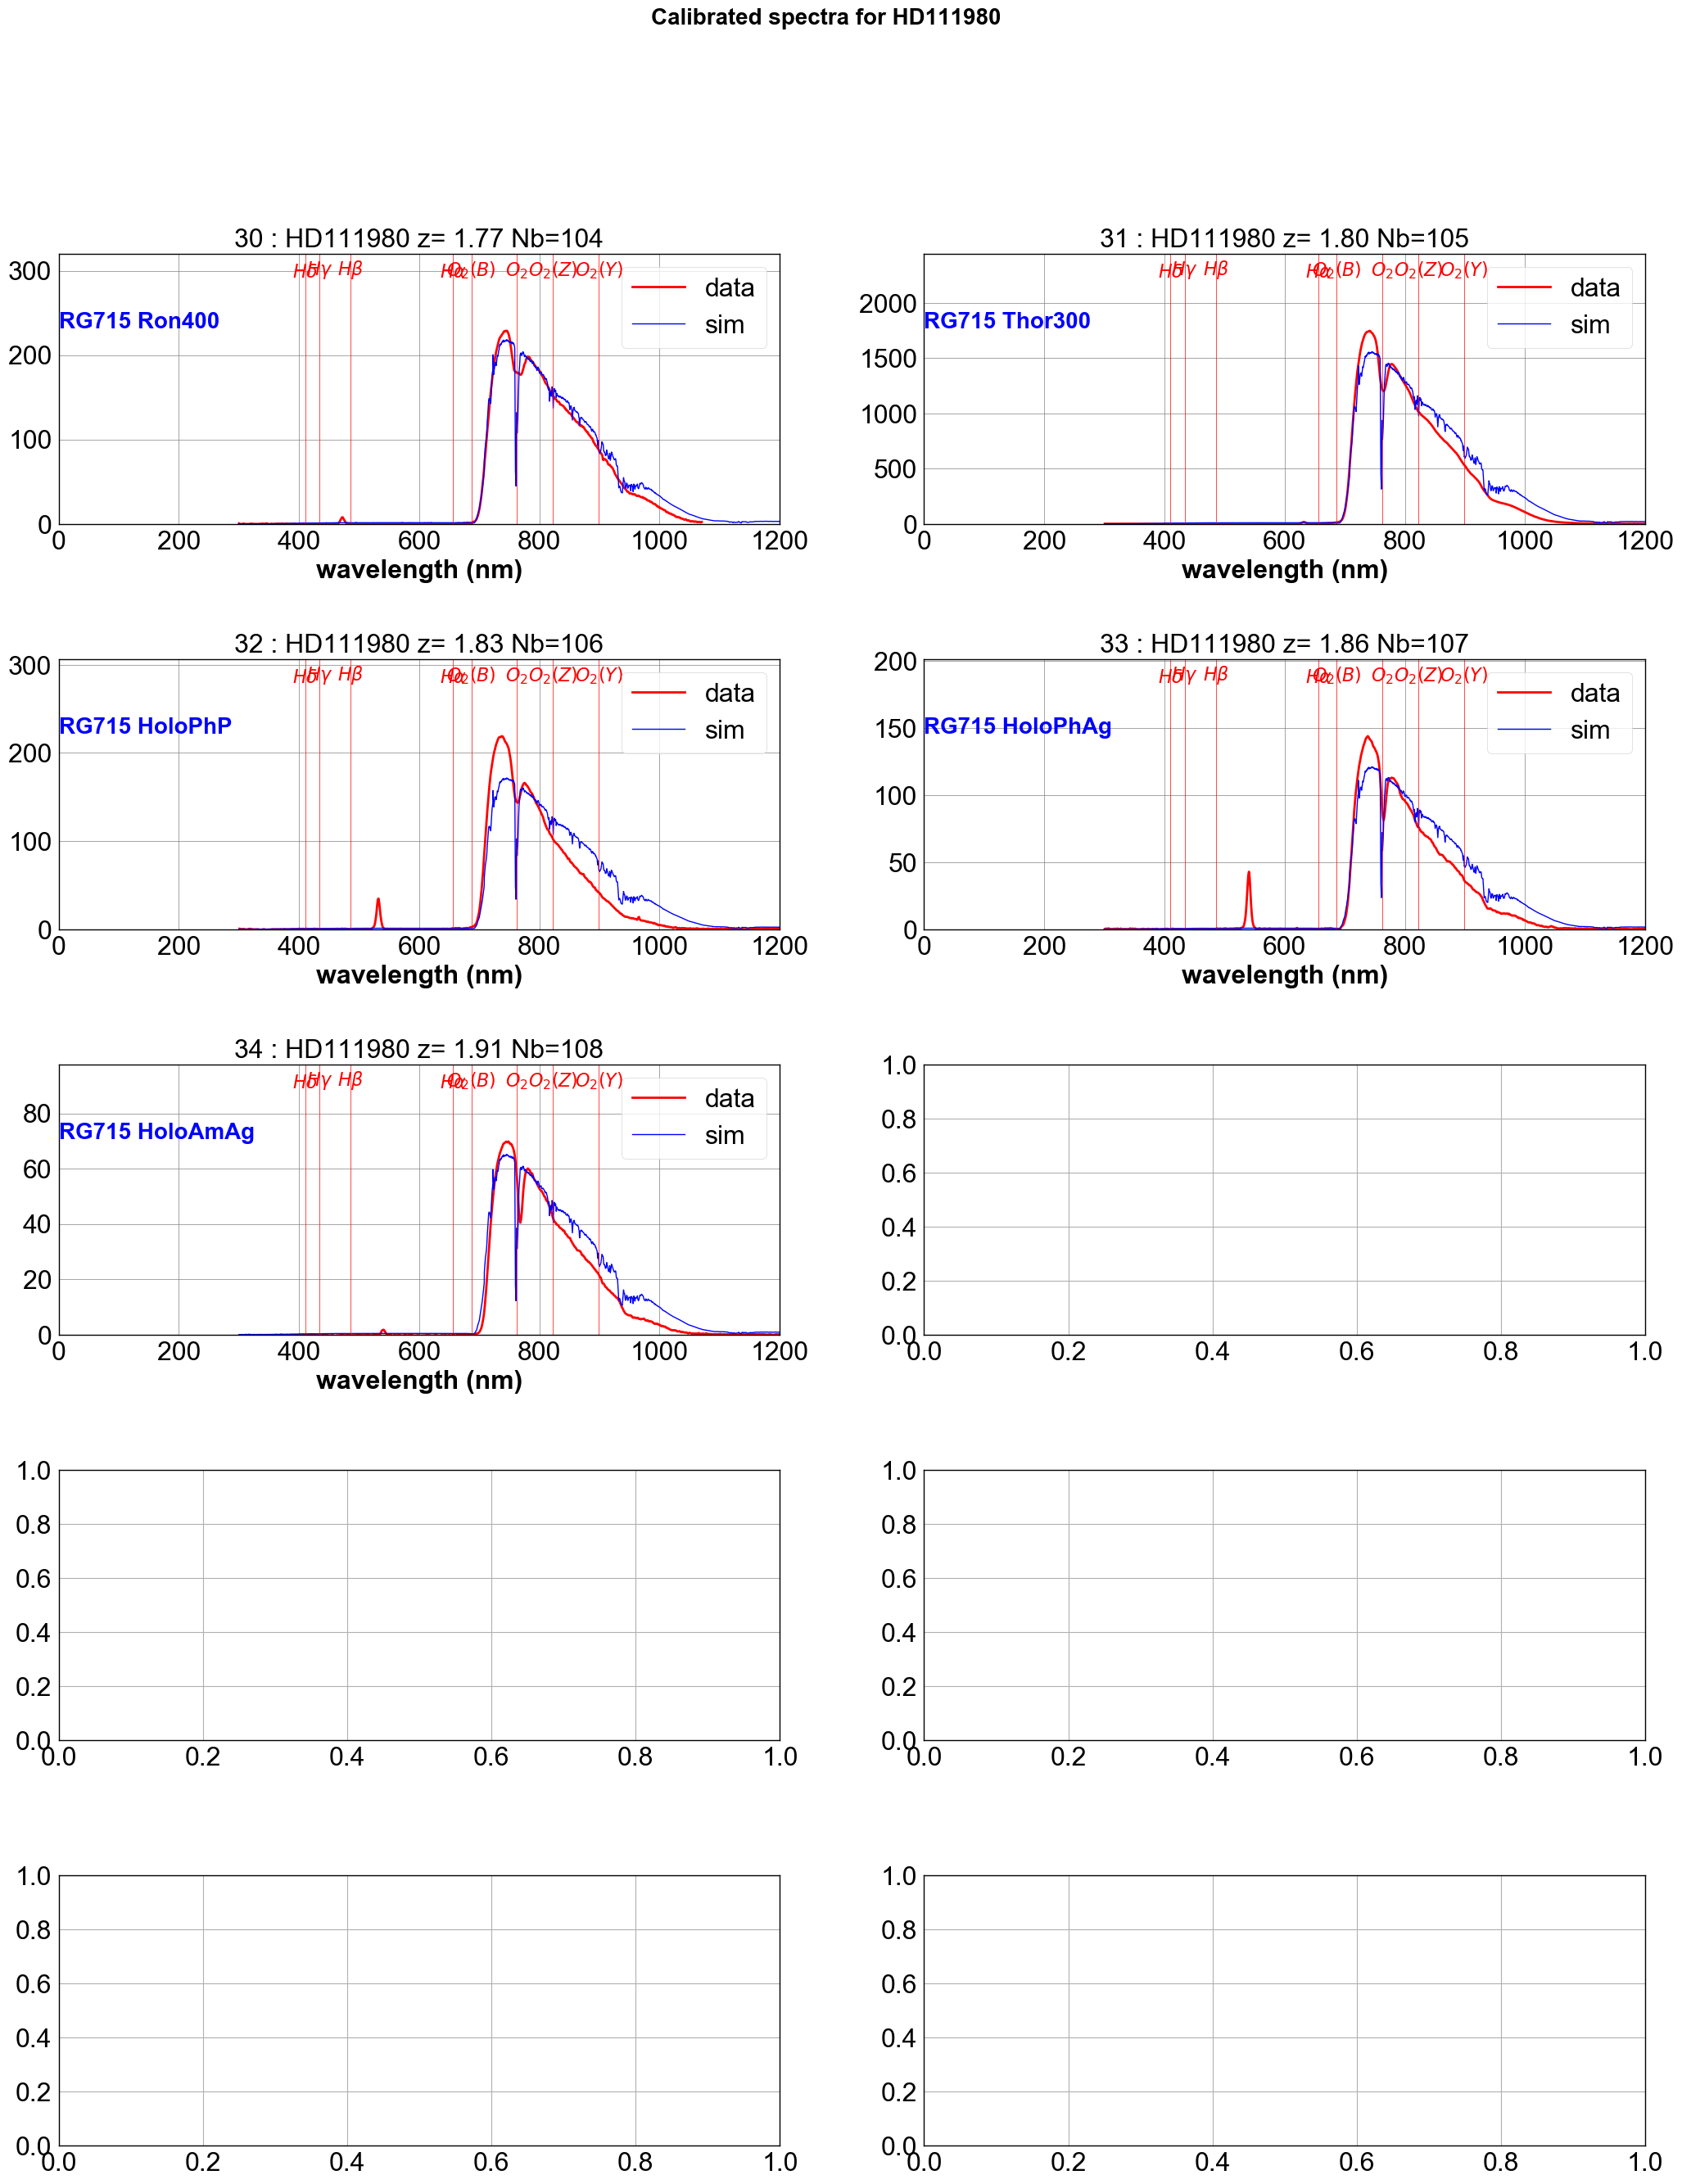

In [31]:
all_calibdatasimfactors=ShowCalibAndSimSpectrainPDF(all_rightspectra_data,all_rightspectra_wl,all_titles,object_name,all_filt,dir_top_images,all_sim_spectra_data,all_sim_spectra_wl)

## About Relative Calibration Factor

In [32]:
all_calibdatasimfactors=np.array(all_calibdatasimfactors)

In [33]:
Thor300_factor=all_calibdatasimfactors[Thor300_index]
Ron400_factor=all_calibdatasimfactors[Ron400_index]
HoloPhP_factor=all_calibdatasimfactors[HoloPhP_index]
HoloPhAg_factor=all_calibdatasimfactors[HoloPhAg_index]
HoloAmAg_factor=all_calibdatasimfactors[HoloAmAg_index]


In [34]:
Thor300_factor_av=np.median(Thor300_factor)
Ron400_factor_av=np.median(Ron400_factor)
HoloPhP_factor_av=np.median(HoloPhP_factor)
HoloPhAg_factor_av=np.median(HoloPhAg_factor)
HoloAmAg_factor_av=np.median(HoloAmAg_factor)

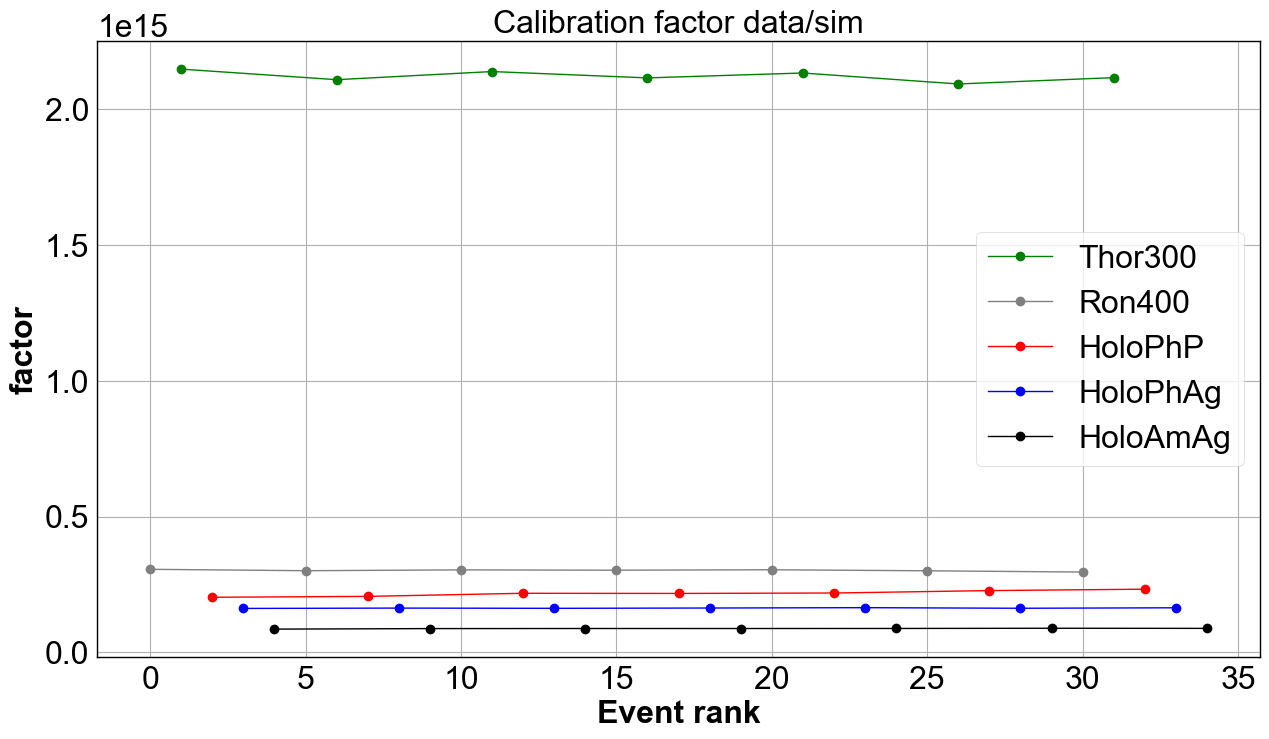

In [35]:
figfilename=os.path.join(dir_top_images,'calib_factor.pdf')

plt.figure(figsize=(15,8))

plt.plot(Thor300_index,Thor300_factor,marker='o',color='green',label='Thor300')
#plt.plot([0,Thor300_index.max()],[Thor300_factor_av,Thor300_factor_av],'g-')

plt.plot(Ron400_index,Ron400_factor,marker='o',color='grey',label='Ron400')
#plt.plot([0,Ron400_index.max()],[Ron400_factor_av,Ron400_factor_av],'-',color='grey')

plt.plot(HoloPhP_index,HoloPhP_factor,marker='o',color='red',label='HoloPhP')
#plt.plot([0,HoloPhP_index.max()],[HoloPhP_factor_av,HoloPhP_factor_av],'r-')


plt.plot(HoloPhAg_index,HoloPhAg_factor,marker='o',color='blue',label='HoloPhAg')
#plt.plot([0,HoloPhAg_index.max()],[HoloPhAg_factor_av,HoloPhAg_factor_av],'b-')

plt.plot(HoloAmAg_index,HoloAmAg_factor,marker='o',color='black',label='HoloAmAg')
#plt.plot([0,HoloAmAg_index.max()],[HoloAmAg_factor_av,HoloAmAg_factor_av],'k-')


plt.grid(True)
plt.legend(loc='best')
plt.title('Calibration factor data/sim')
plt.xlabel("Event rank")
plt.ylabel("factor")
plt.savefig(figfilename) 

In [52]:
all_titles

['HD111980 z= 1.18 Nb=74',
 'HD111980 z= 1.19 Nb=75',
 'HD111980 z= 1.19 Nb=76',
 'HD111980 z= 1.20 Nb=77',
 'HD111980 z= 1.22 Nb=78',
 'HD111980 z= 1.23 Nb=79',
 'HD111980 z= 1.24 Nb=80',
 'HD111980 z= 1.25 Nb=81',
 'HD111980 z= 1.26 Nb=82',
 'HD111980 z= 1.28 Nb=83',
 'HD111980 z= 1.30 Nb=84',
 'HD111980 z= 1.31 Nb=85',
 'HD111980 z= 1.32 Nb=86',
 'HD111980 z= 1.34 Nb=87',
 'HD111980 z= 1.36 Nb=88',
 'HD111980 z= 1.38 Nb=89',
 'HD111980 z= 1.40 Nb=90',
 'HD111980 z= 1.41 Nb=91',
 'HD111980 z= 1.43 Nb=92',
 'HD111980 z= 1.45 Nb=93',
 'HD111980 z= 1.48 Nb=94',
 'HD111980 z= 1.50 Nb=95',
 'HD111980 z= 1.52 Nb=96',
 'HD111980 z= 1.54 Nb=97',
 'HD111980 z= 1.57 Nb=98',
 'HD111980 z= 1.61 Nb=99',
 'HD111980 z= 1.63 Nb=100',
 'HD111980 z= 1.66 Nb=101',
 'HD111980 z= 1.68 Nb=102',
 'HD111980 z= 1.72 Nb=103',
 'HD111980 z= 1.77 Nb=104',
 'HD111980 z= 1.80 Nb=105',
 'HD111980 z= 1.83 Nb=106',
 'HD111980 z= 1.86 Nb=107',
 'HD111980 z= 1.91 Nb=108']

In [51]:
all_filt

['RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg',
 'RG715 Ron400',
 'RG715 Thor300',
 'RG715 HoloPhP',
 'RG715 HoloPhAg',
 'RG715 HoloAmAg']

In [36]:
sel=0
thespectrum=all_rightspectra_data[sel]

In [56]:
def ShowOneSpectrum(sel):
    """
    ShowOneSpectrum
    ================
    """

    XMIN=600
    XMAX=1100

    thespectrum=all_rightspectra_data[sel]
    thewl=all_rightspectra_wl[sel]
    ymin=thespectrum.min()
    ymax=thespectrum.max()*1.1
    
    wl_sim=all_sim_spectra_wl[sel]
    sim_spec=all_sim_spectra_data[sel]*all_calibdatasimfactors[sel]
    fig, ax = plt.subplots(1, 1, figsize=(15,8))


    ax.plot(thewl,thespectrum,'r-',lw=3,label='data')
    ax.plot(wl_sim,sim_spec,'b-',lw=2,label='sim')

    max_y_to_plot=thespectrum[:].max()*1.2
    ax.set_ylim(0.,max_y_to_plot)
    
    if all_filt[sel]=='RG715 HoloPhAg':
    
        ax.text(XMAX-210,max_y_to_plot*1.1/1.4,"RG715 + Argentic phase hologram",verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    else:
        ax.text(XMAX-110,max_y_to_plot*1.1/1.4, all_filt[sel],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
        
    
    
    ax.set_title(all_titles[sel],fontweight="bold")
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='grey', linewidth=1.0)
    ##ax.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
        
    YMIN=0.
    YMAX=max_y_to_plot
    
    for line in LINES:
        #if line == O2 or line == HALPHA or line == HBETA or line == HGAMMA or line == HDELTA or line == O2B or line == O2Y or line == O2Z:
        if line == O2 or line == O2Y or line == O2Z: 
            ax.plot([line['lambda'],line['lambda']],[YMIN,YMAX],'-',color='red',lw=0.5)
            ax.text(line['lambda'],0.9*(YMAX-YMIN),line['label'],verticalalignment='bottom', horizontalalignment='center',color='red', fontweight='bold',fontsize=16)
    

    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(XMIN,XMAX)
    ax.set_xlabel("$\lambda$ (nm)",fontweight="bold")
    ax.set_ylabel("ADU",fontweight="bold")
    ax.grid(b=False)
    
    figname='one_intput_calibrated_spectra_{}.pdf'.format(sel)
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.tight_layout()
    fig.savefig(figfilename)

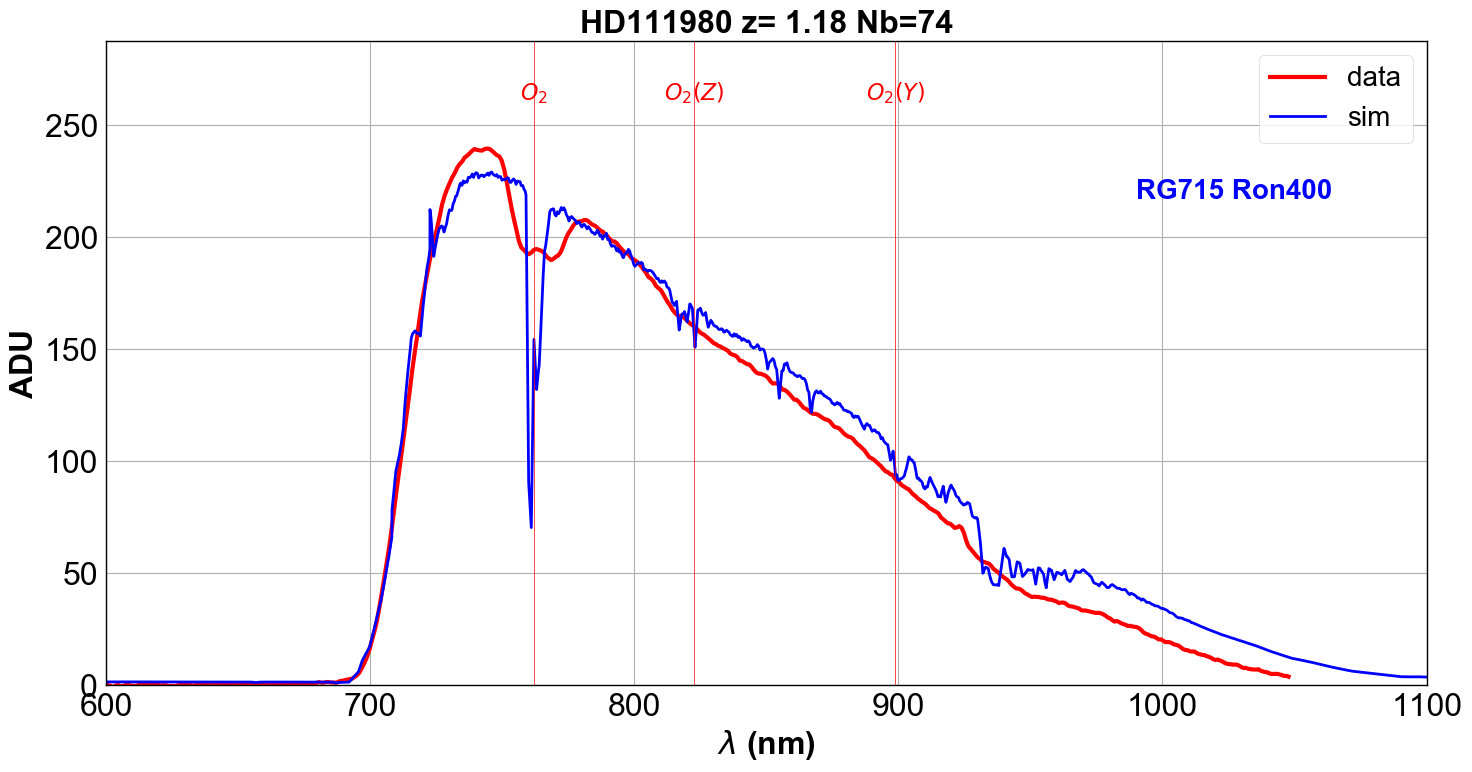

In [54]:
ShowOneSpectrum(0)

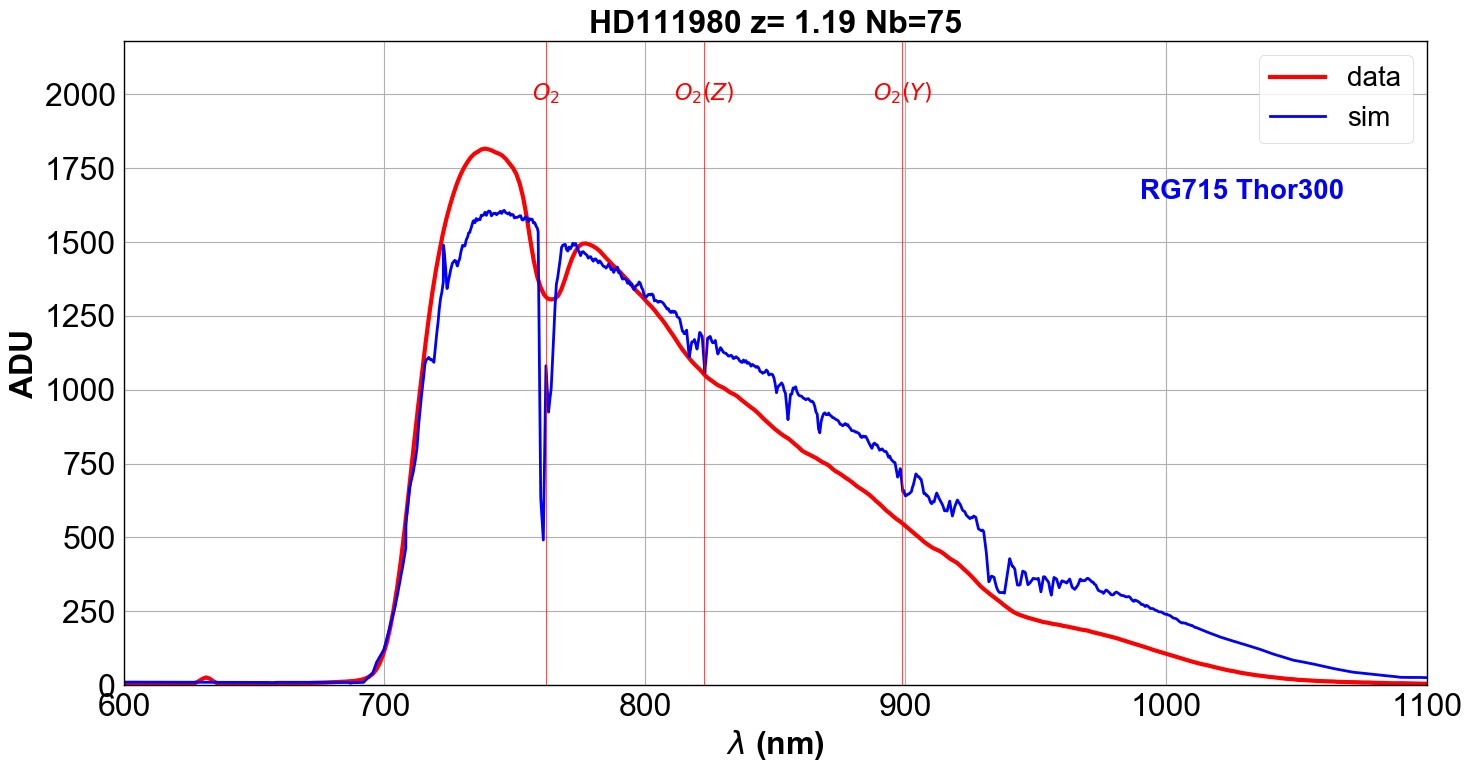

In [39]:
ShowOneSpectrum(1)

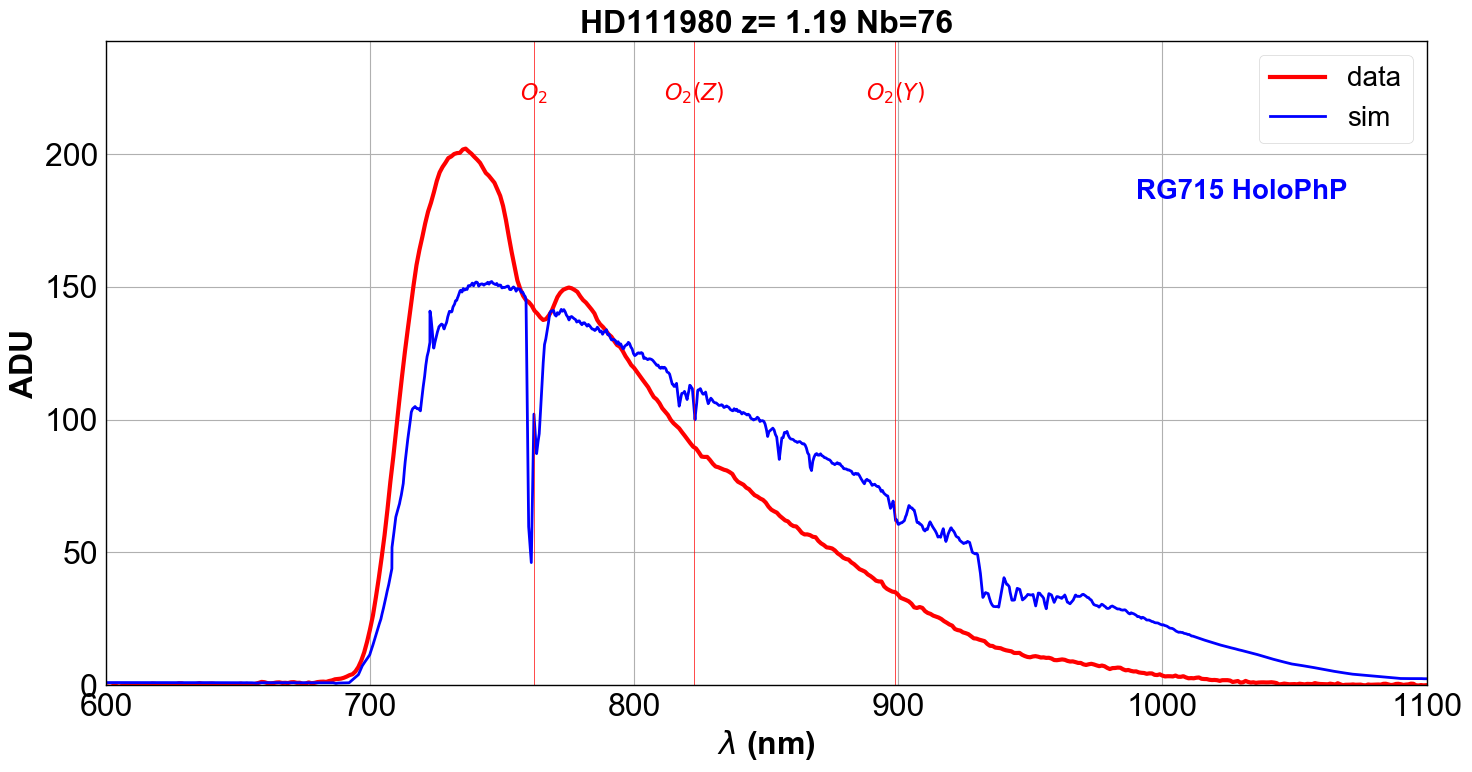

In [40]:
ShowOneSpectrum(2)

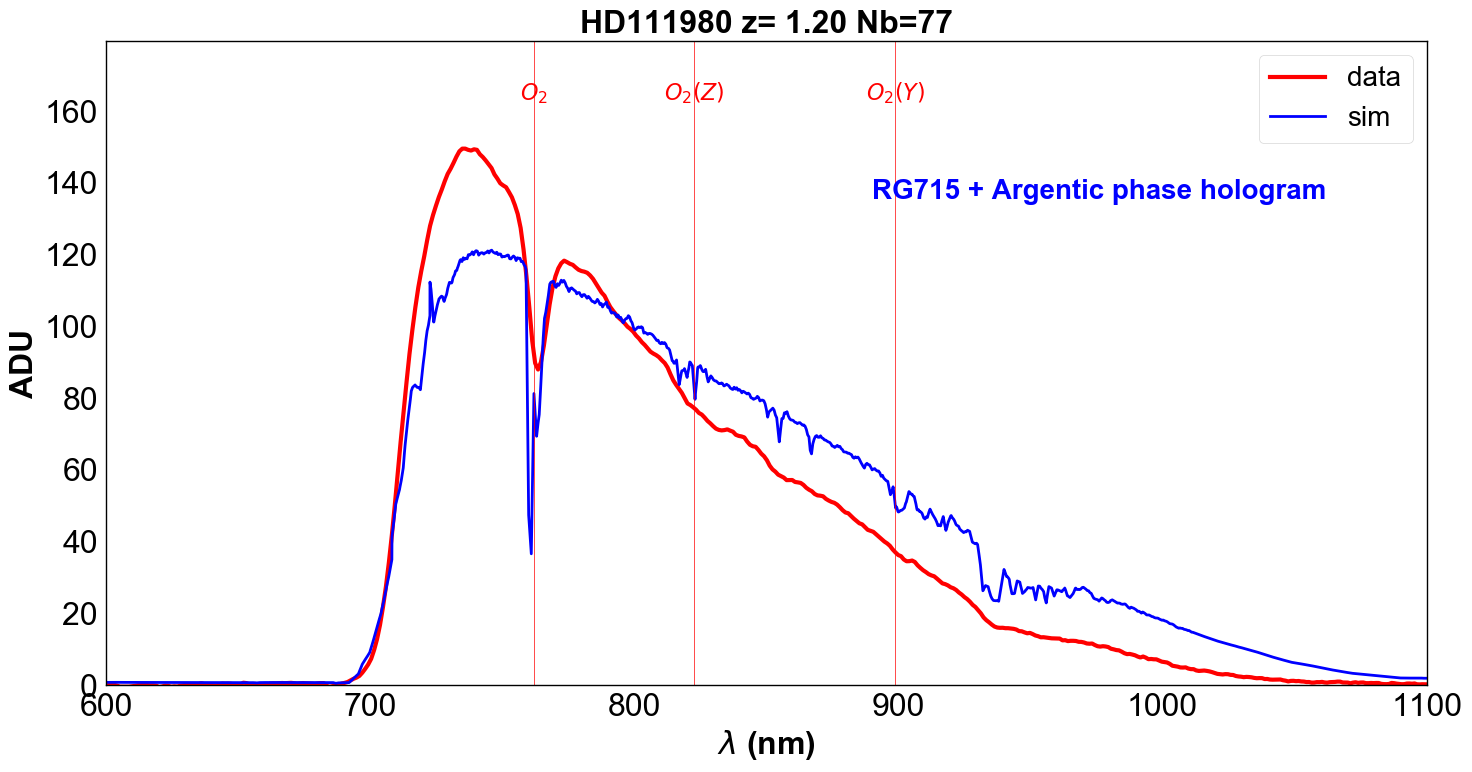

In [57]:
ShowOneSpectrum(3)

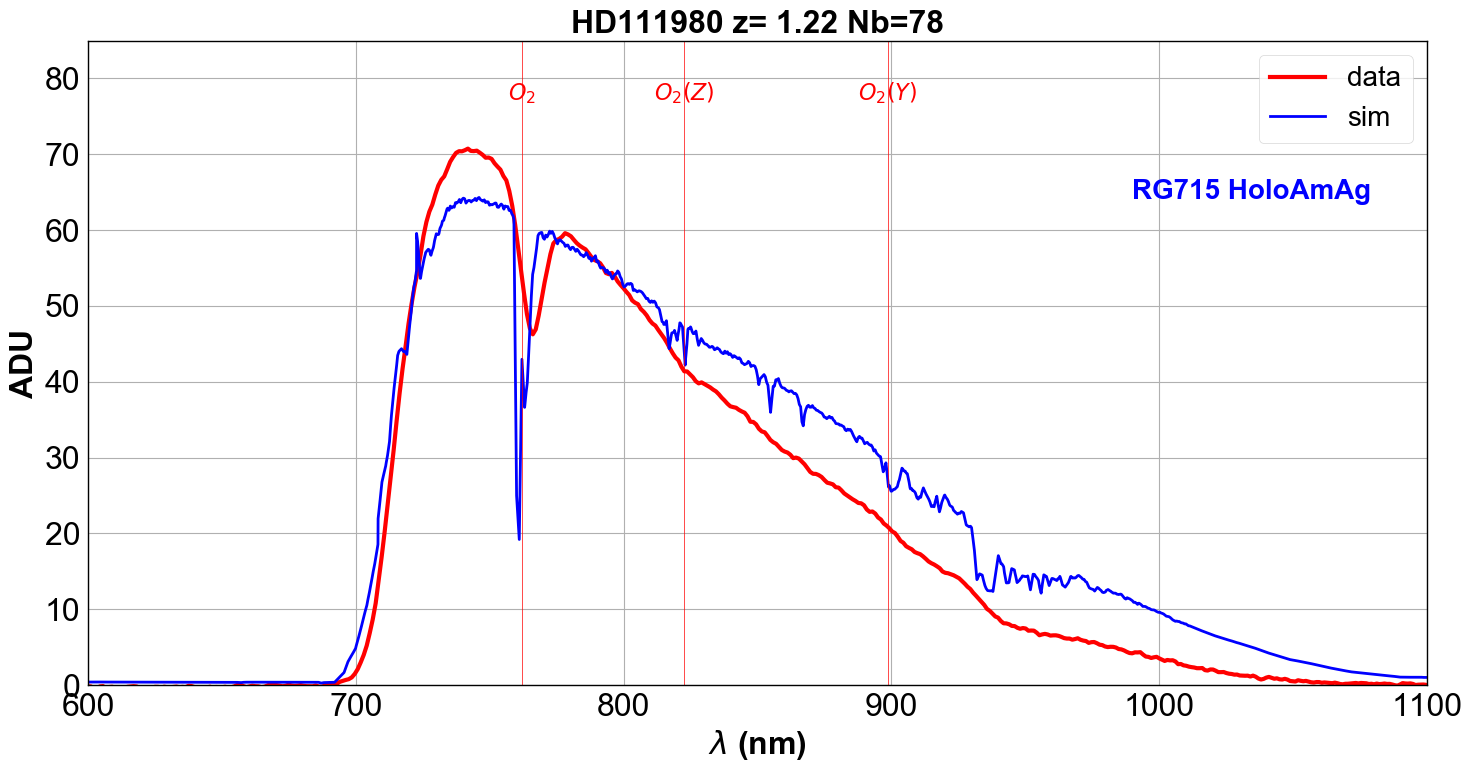

In [42]:
ShowOneSpectrum(4)

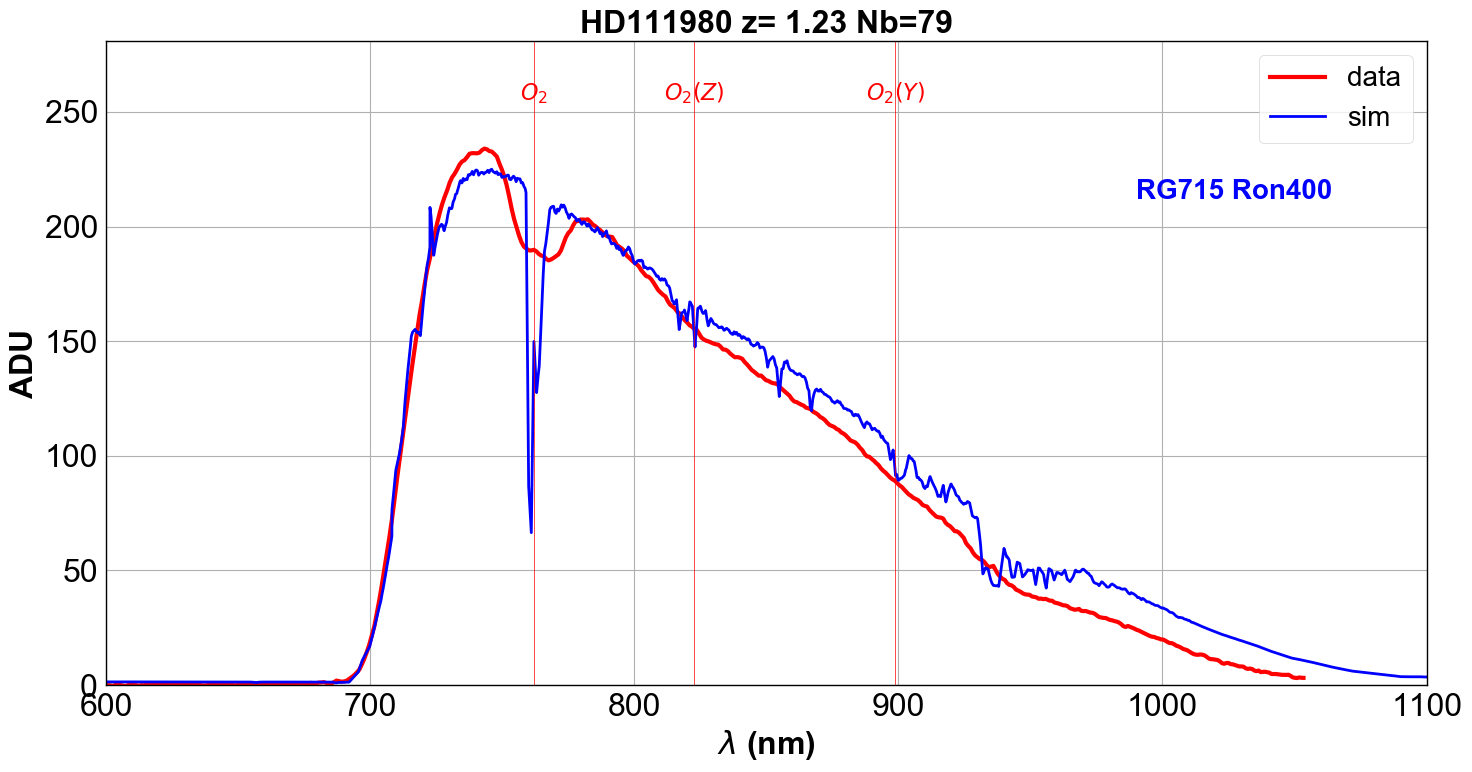

In [43]:
ShowOneSpectrum(5)

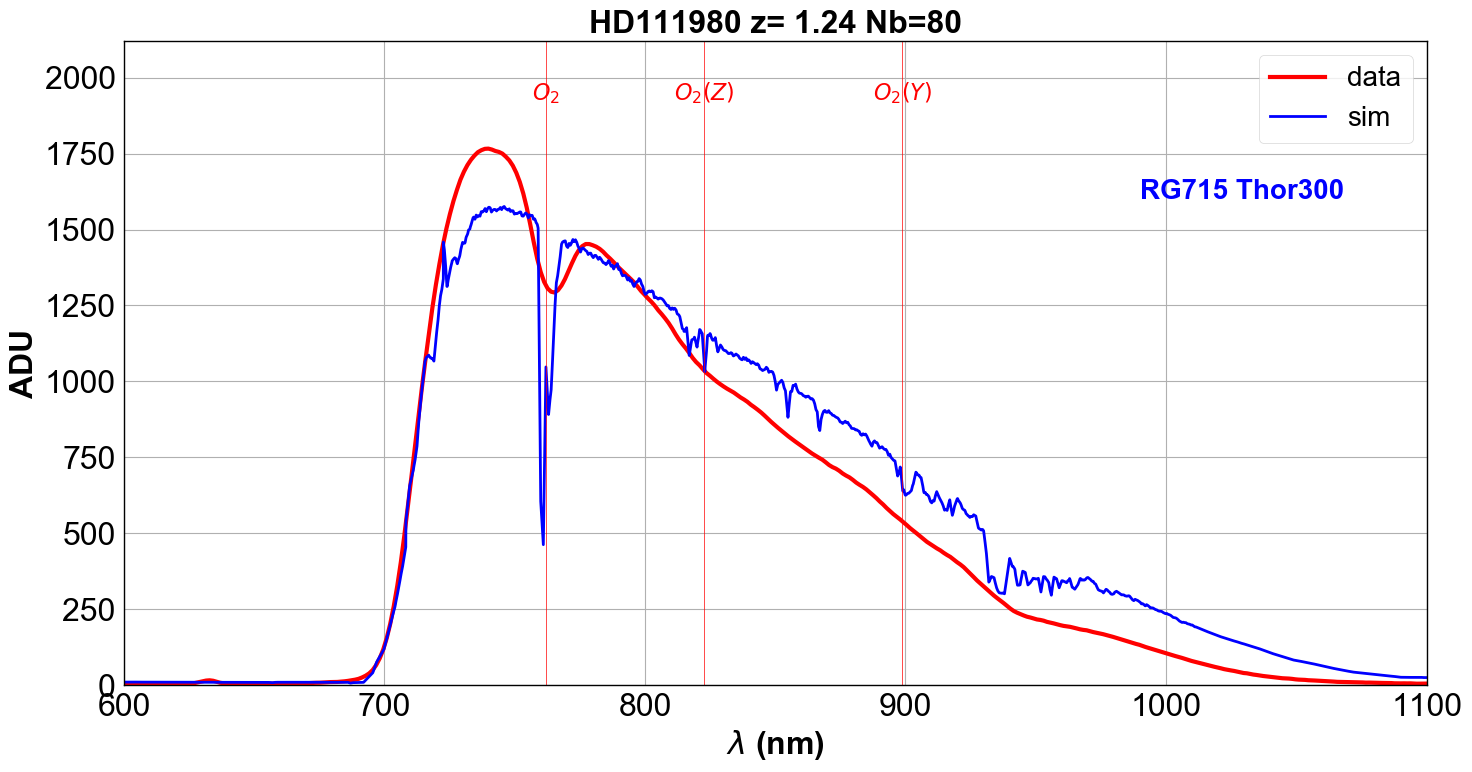

In [44]:
ShowOneSpectrum(6)

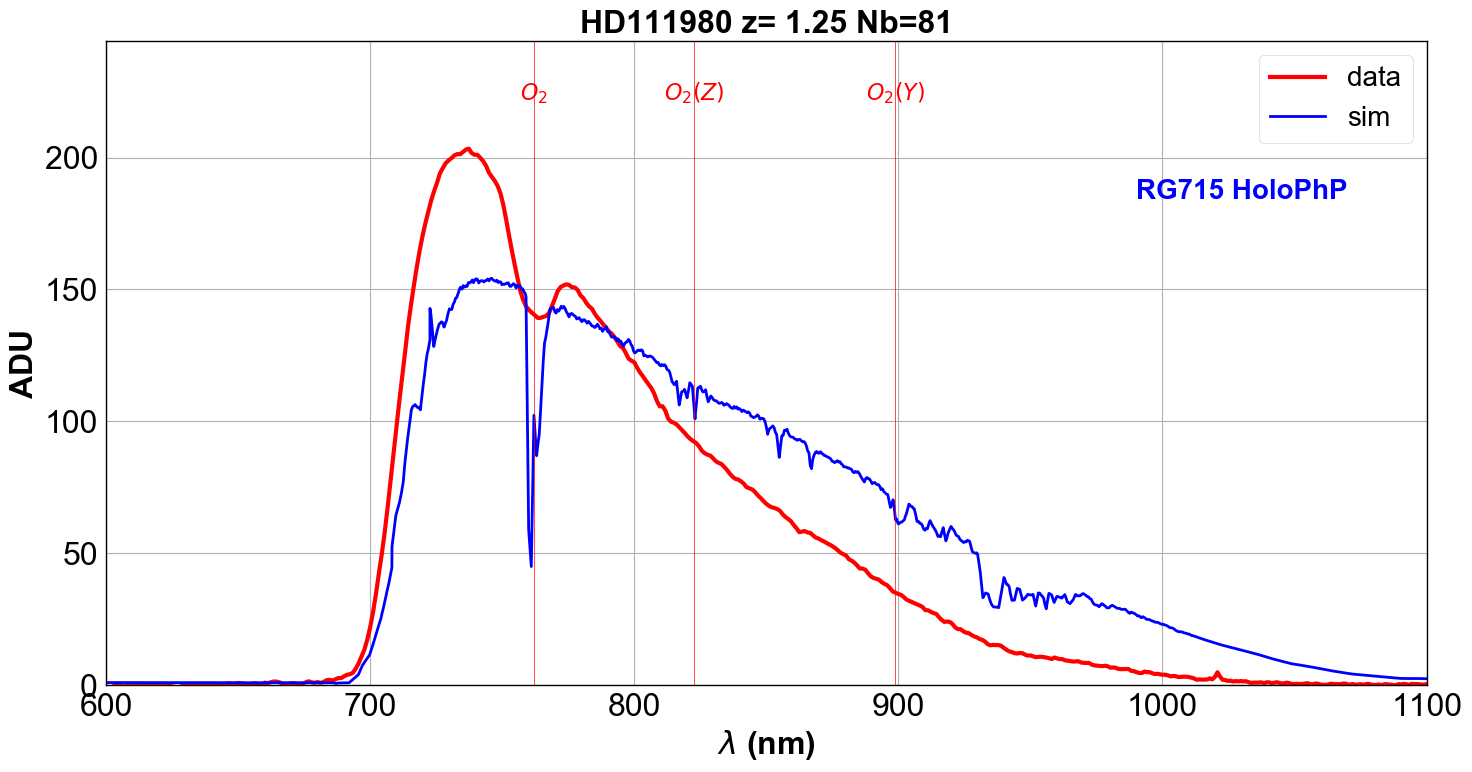

In [45]:
ShowOneSpectrum(7)

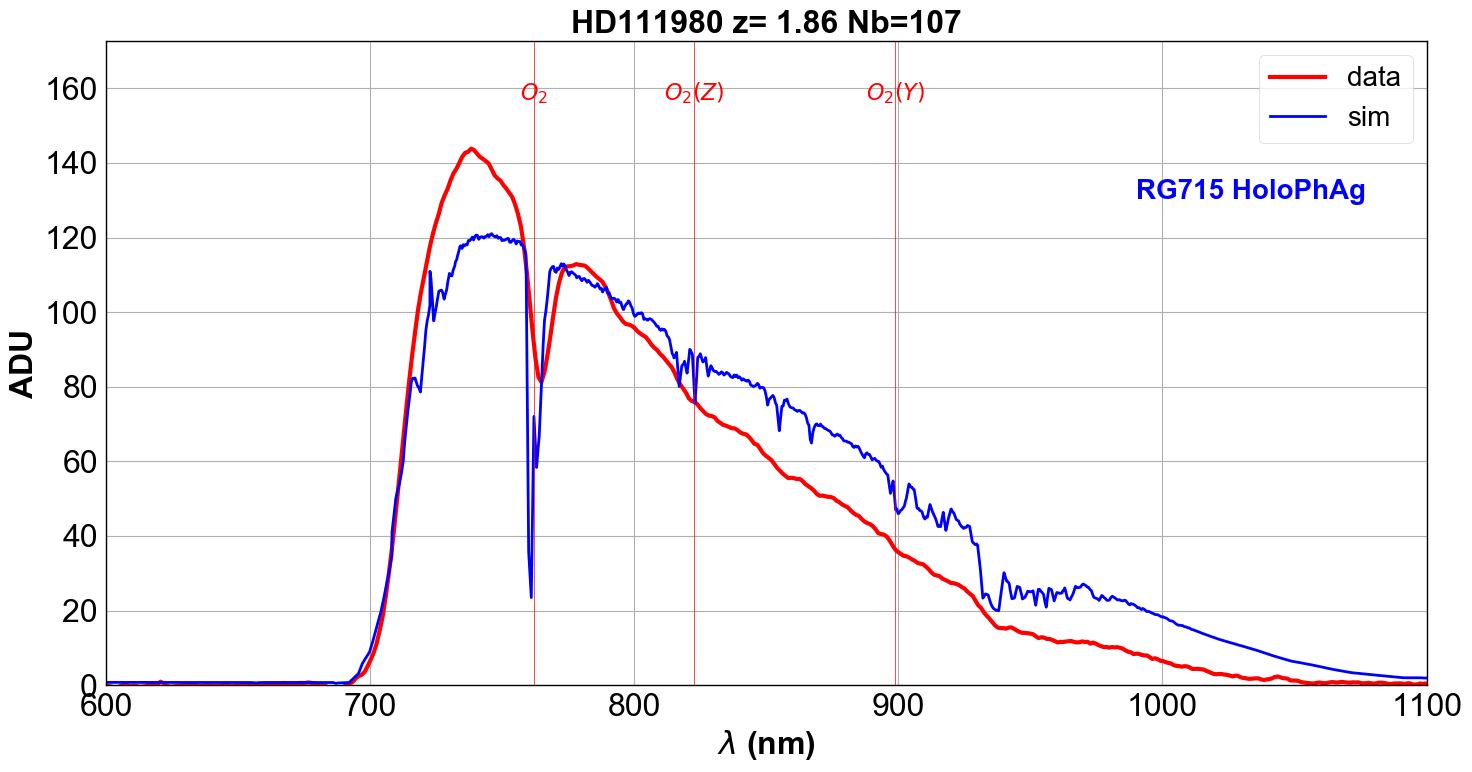

In [46]:
ShowOneSpectrum(33)

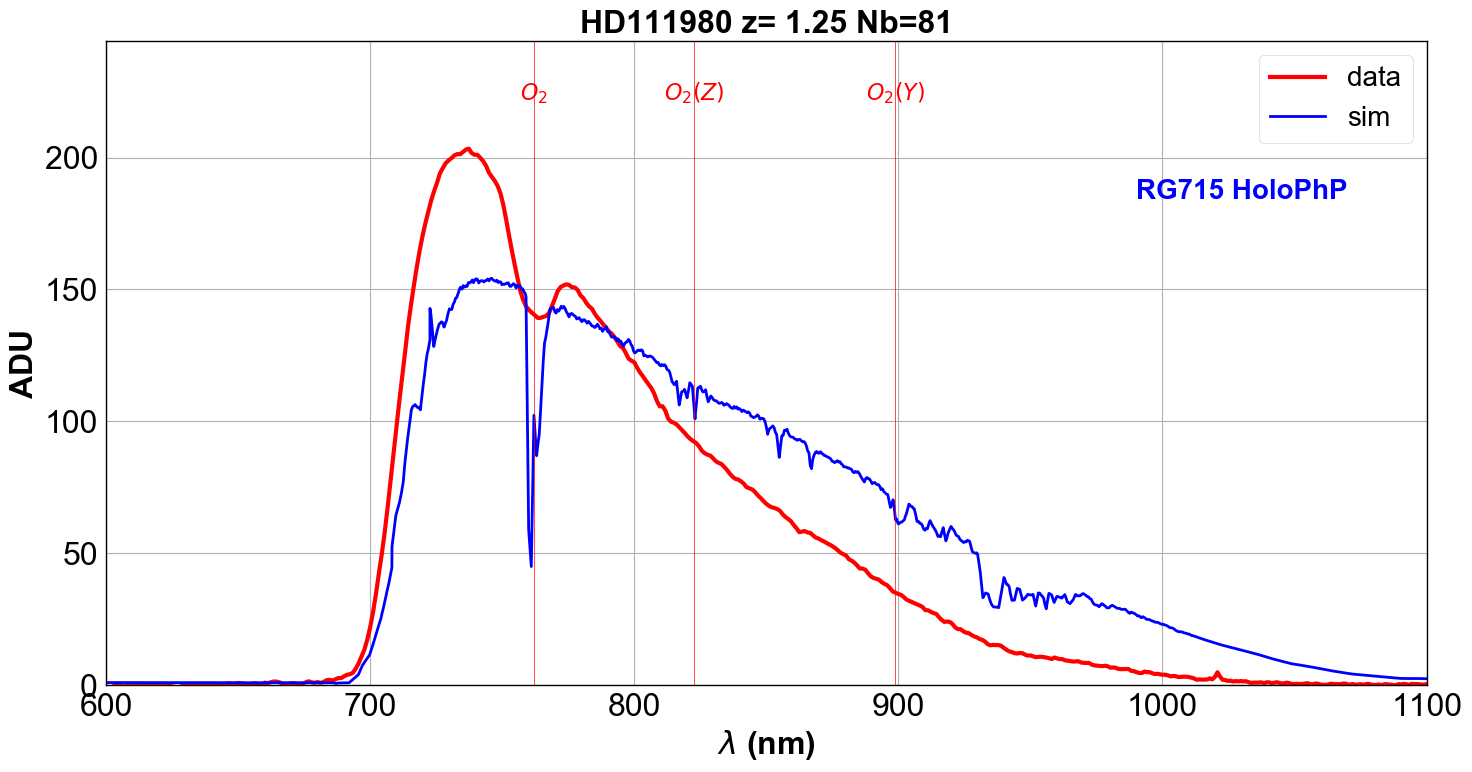

In [47]:
ShowOneSpectrum(7)

In [48]:
def ShowOneSpectrumNextFilt(sel):
    """
    ShowOneSpectrum
    ================
    """
    
    XMIN=600
    XMAX=1100

    NBSPECTOPLOT=5
    
    the_spectra= []
    the_wl=[]
    the_max = []
    the_label= []
    
    for i in np.arange(NBSPECTOPLOT):

        the_spectrum=all_rightspectra_data[sel+i]
        thewl=all_rightspectra_wl[sel+i]
        theymin=the_spectrum.min()
        theymax=the_spectrum.max()
        thelabel=all_filt[sel+i]
        
        the_spectra.append(the_spectrum)
        the_wl.append(thewl)
        the_max.append(theymax)
        the_label.append(thelabel)

        
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    for i in np.arange(NBSPECTOPLOT):        
        ax.plot(the_wl[i],the_spectra[i],lw=3,label=the_label[i])

 
        
    max_y_to_plot=(np.array(the_max)).max()
    ymin=0
    ymax=max_y_to_plot
    ax.set_ylim(0.,max_y_to_plot*1.2)
    
    ax.set_title(all_titles[sel])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='grey', linewidth=1.0)
    #ax.grid(b=True, which='minor', color='grey', linewidth=0.5)

    YMIN=0.
    YMAX=max_y_to_plot*1.1
    
    for line in LINES:
        #if line == O2 or line == HALPHA or line == HBETA or line == HGAMMA or line == HDELTA or line == O2B or line == O2Y or line == O2Z:
        if line == O2 or line == HALPHA or line == O2B or line == O2Y or line == O2Z:
            ax.plot([line['lambda'],line['lambda']],[YMIN,YMAX],'-',color='red',lw=0.5)
            ax.text(line['lambda'],0.9*(YMAX-YMIN),line['label'],verticalalignment='bottom', horizontalalignment='center',color='red', fontweight='bold',fontsize=16)
    
    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(XMIN,XMAX)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("ADU")
    
    
    figname='five_intput_calibrated_spectra_{}.pdf'.format(sel)
    figfilename=os.path.join(dir_top_images,figname)
    fig.savefig(figfilename)

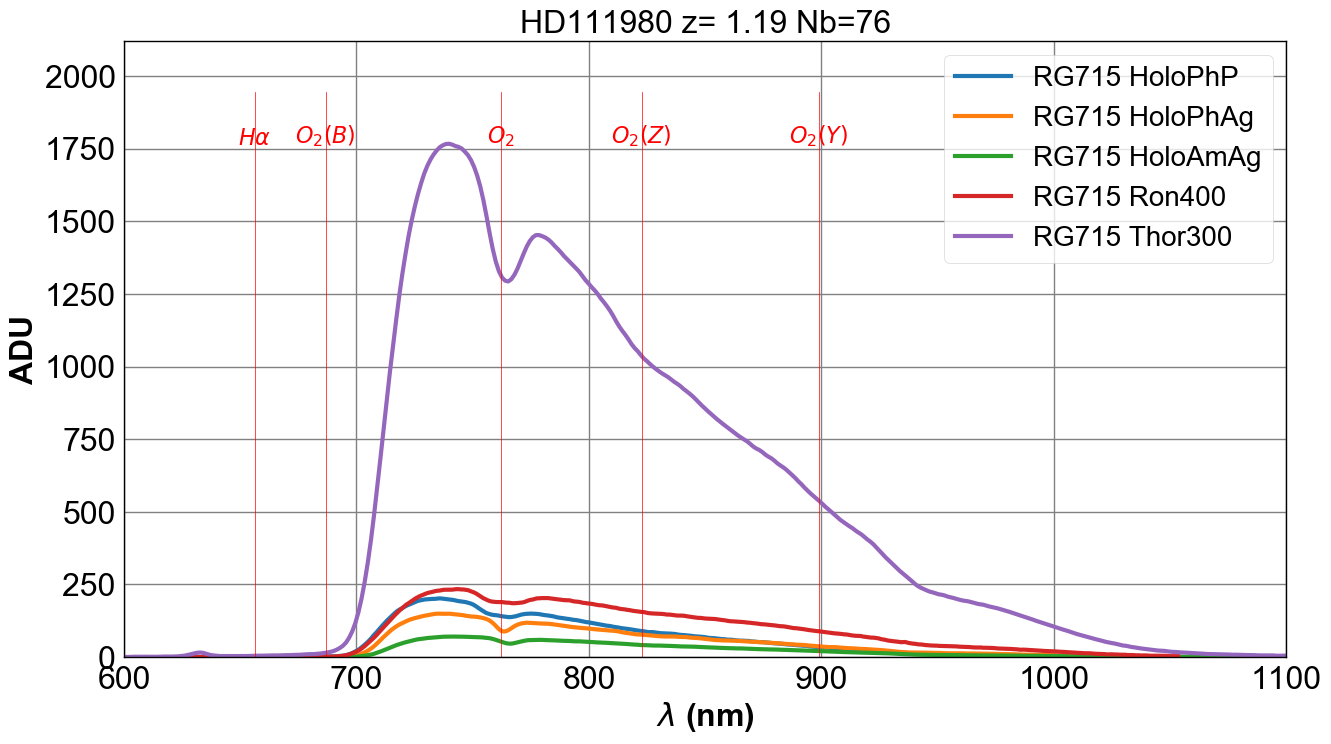

In [49]:
ShowOneSpectrumNextFilt(2)